In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

In [4]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [5]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [6]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [8]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [9]:
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_62nd.h5", 'r') as hf:
    flatfield_1d_FeXIV_62nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

In [10]:
def calculate_intensity(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2):
    image_sliced = image[ypix_slice, wavelength_slice]
    wvl_sliced = wvl[wavelength_slice]
    intensity_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
    for ii in range(ypix_slice.stop - ypix_slice.start):
        intensity_sliced[ii] = calculate_intensity_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:])

    return intensity_sliced

def fit_spectra(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2,nbin=5,plot_fit=False):
    image_sliced = image[ypix_slice, wavelength_slice]
    if (nbin == 1) or (nbin is None):
        pass
    else:
        image_sliced = np.average(image_sliced.reshape(-1,nbin,image_sliced.shape[1]),axis=1)
    wvl_sliced = wvl[wavelength_slice]
    fit_params = np.zeros((4,image_sliced.shape[0]))

    for ii in range(image_sliced.shape[0]):
        fit_params[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:],
                                plot_fit=plot_fit)

    return fit_params

    
def calculate_intensity_single(cont_wvl, cont_int, wvl, int):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)
    int_sum = np.sum(int_res)

    return int_sum


def fit_spectra_single(cont_wvl, cont_int, wvl, int,plot_fit=False):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)

    fit_model = SpectrumFitSingle(data=int_res,wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=0.1)

    try:
        fit_model.run_lse()
    except RuntimeError:
        pass
    if plot_fit:
        fit_model.plot(plot_params=False)
        print(fit_model.fwhm_fit)

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0],
                     cont_fit_poly(fit_model.line_wvl_fit[0]) + fit_model.int_cont_fit])

/tmp/ipykernel_93377/1785486557.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(np.arange(green_frame_example.header["NAXIS1"]),


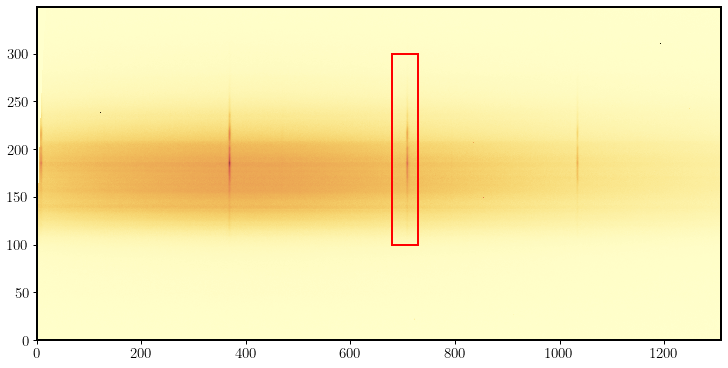

In [11]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
green_frame_example = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(green_frame_example.header["NAXIS1"]),
                np.arange(green_frame_example.header["NAXIS2"]),
                green_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeXIV_62nd_xslice = slice(680,730)
FeXIV_62nd_yslice = slice(100,300)
cutout_rectangle_62nd = patches.Rectangle((FeXIV_62nd_xslice.start, FeXIV_62nd_yslice.start), 
                    FeXIV_62nd_xslice.stop - FeXIV_62nd_xslice.start,
                    FeXIV_62nd_yslice.stop - FeXIV_62nd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_62nd)
ax.tick_params(labelsize=15)

In [12]:
starttime_green_ext = datetime(2017,8,21,17,45,36)
green_fit_matrix_ext = np.full((4,350,168),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data

    FeXIV_fit_ = fit_spectra(green_frame_.data/flatfield_1d_FeXIV_62nd[:,np.newaxis]/exptime,
    green_frame_wavelength_/62./10., FeXIV_62nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=None)

    green_fit_matrix_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
green_fit_matrix_ext = np.flip(green_fit_matrix_ext,axis=(1,2))

/home/yjzhu/SOLAR/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/yjzhu/SOLAR/MyPy/juanfit.py:268: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))


In [13]:
green_fit_matrix_bin_ext = np.full((4,70,168),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data

    FeXIV_fit_ = fit_spectra(green_frame_.data/flatfield_1d_FeXIV_62nd[:,np.newaxis]/exptime,
    green_frame_wavelength_/62./10., FeXIV_62nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=5, plot_fit=False)

    green_fit_matrix_bin_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
green_fit_matrix_bin_ext = np.flip(green_fit_matrix_bin_ext,axis=(1,2))

In [14]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-43,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,83.5,168)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [15]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

/tmp/ipykernel_93377/230594071.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
/tmp/ipykernel_93377/230594071.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
/tmp/ipykernel_93377/230594071.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated sinc

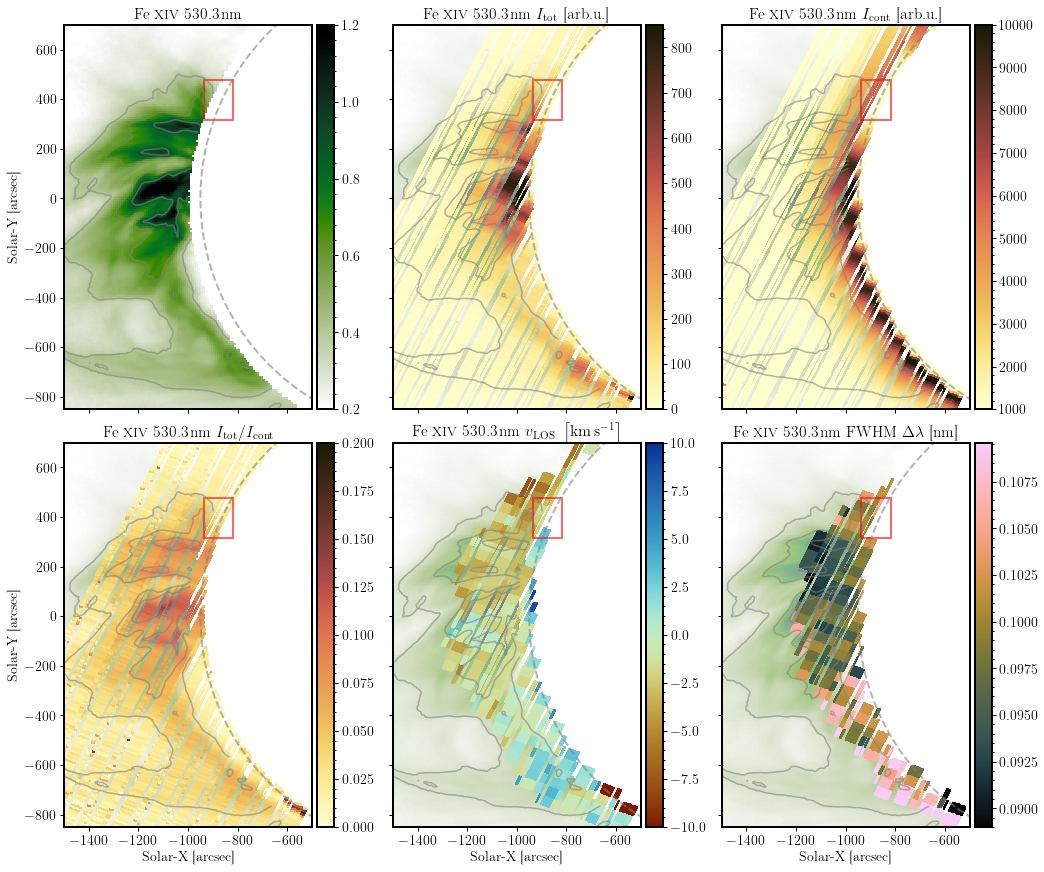

In [16]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850)


plot_colorbar(im2, ax2,width=colorbar_width)

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.2)

plot_colorbar(im4, ax4,width=colorbar_width)

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.roma,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 100)] = np.nan
fwhm_masked[green_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                fwhm_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.089,vmax=0.1096)

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm FWHM $\Delta \lambda$ [nm]",fontsize=16)

xlim_zoomin = [-1500,-500]
ylim_zoomin = [-850,700]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

/tmp/ipykernel_93377/1444083741.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(np.arange(red_frame_example.header["NAXIS1"]),


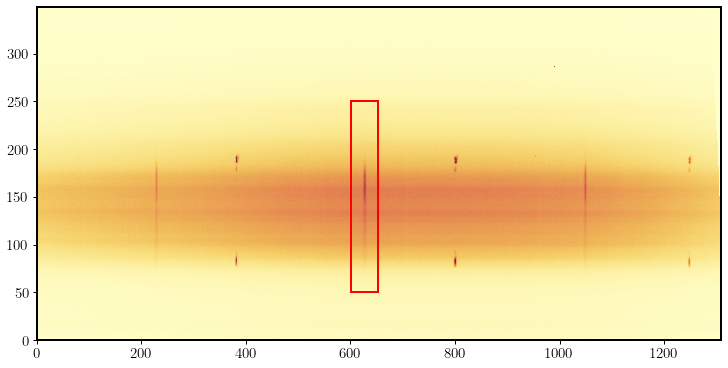

In [17]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
red_frame_example = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(red_frame_example.header["NAXIS1"]),
                np.arange(red_frame_example.header["NAXIS2"]),
                red_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeX_52nd_xslice = slice(602,652)
FeX_52nd_yslice = slice(50,250)
cutout_rectangle_52nd = patches.Rectangle((FeX_52nd_xslice.start, FeX_52nd_yslice.start), 
                    FeX_52nd_xslice.stop - FeX_52nd_xslice.start,
                    FeX_52nd_yslice.stop - FeX_52nd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_52nd)
ax.tick_params(labelsize=15)

In [18]:
starttime_red_ext = datetime(2017,8,21,17,45,36)
red_fit_matrix_ext = np.full((4,350,168),np.nan,dtype=np.float64)
for ii, row_ in totality_red_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

    FeX_fit_ = fit_spectra(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,
    red_frame_wavelength_/52./10., FeX_52nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=None)

    red_fit_matrix_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
red_fit_matrix_ext = np.flip(red_fit_matrix_ext,axis=(1,2))

/home/yjzhu/SOLAR/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/yjzhu/SOLAR/MyPy/juanfit.py:268: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))


In [19]:
red_fit_matrix_bin_ext = np.full((4,70,168),np.nan,dtype=np.float64)
for ii, row_ in totality_red_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

    FeX_fit_ = fit_spectra(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,
    red_frame_wavelength_/52./10., FeX_52nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=5, plot_fit=False)

    red_fit_matrix_bin_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
red_fit_matrix_bin_ext = np.flip(red_fit_matrix_bin_ext,axis=(1,2))

In [20]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-43,125,1,dtype=np.float64) + 8
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,83.5,168) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

/tmp/ipykernel_93377/3313254488.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
/tmp/ipykernel_93377/3313254488.py:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
/tmp/ipykernel_93377/3313254488.py:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

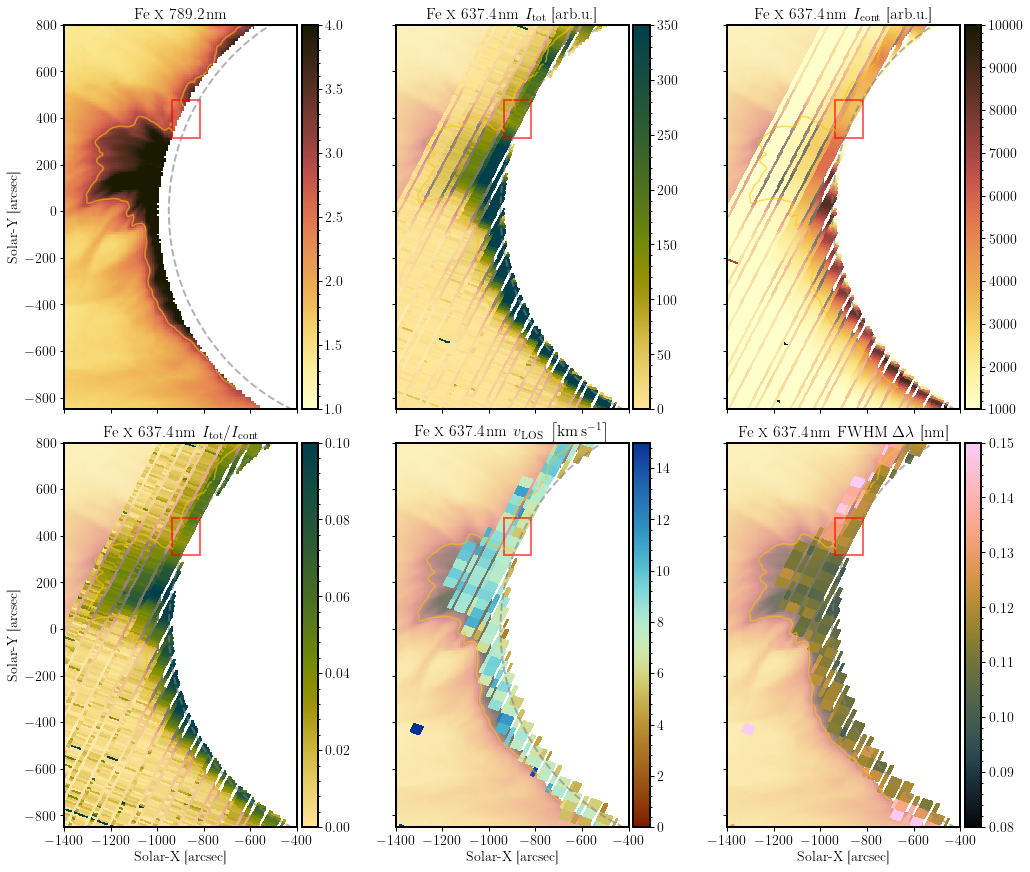

In [21]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

colorbar_width = "7%"

slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=350)


plot_colorbar(im2, ax2,width=colorbar_width)

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
red_cont_masked[red_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)


red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width)

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.roma,rasterized=True,vmin=0,vmax=15)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
fwhm_masked[red_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                fwhm_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.08,vmax=0.15)

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{x} 789.2\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm FWHM $\Delta \lambda$ [nm]",fontsize=16)

xlim_zoomin = [-1400,-400]
ylim_zoomin = [-850,800]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)